## Face detection using HOG+SVM+HEATMAP

##### General Functions for Extract Features

In [1]:
import cv2
import numpy as np

# Get Histogram
def gethist(mag, angle, binsize):
    binsize=9
    hist=np.zeros((binsize,), dtype=np.int32)
    step=180//binsize
    bins=(angle//step).flatten()
    mag=mag.flatten()
    for i,m in zip(bins,mag):
        hist[i]+=m
    return hist

# Using L1-norm to normalize, return block
def trans(cells):
    block=cells.flatten().astype(np.float32)
    factor=np.sqrt(np.sum(abs(block))+1e-6)
    block/=factor
    return block

# Get HOG characteristics
def gethog(img):
    # graying
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # calculate gradient
    dx=cv2.Sobel(gray,cv2.CV_16S,1,0)
    dy=cv2.Sobel(gray,cv2.CV_16S,0,1)
    s=1e-3
    # calculate angle
    angle=np.int32(np.arctan(dy/(dx+s))*180/np.pi)+90
    dy=cv2.convertScaleAbs(dy)
    dx=cv2.convertScaleAbs(dx)
    # calculate gradient
    mag=cv2.addWeighted(dx,0.5,dy,0.5,0)
    # splitting into cell
    cellsize=8
    binsize=9
    imgh,imgw = gray.shape[:2]
    cellh,cellw = (imgh // cellsize, imgw // cellsize)

    cells = np.zeros((cellh, cellw, binsize), dtype=np.int32)
    for i in range(cellh):
        cellrow = cellsize * i
        for j in range(cellw):
            cellcol = cellsize * j
            cells[i,j] = gethist(mag[cellrow:cellrow+cellsize, cellcol:cellcol+cellsize],
                angle[cellrow:cellrow+cellsize, cellcol:cellcol+cellsize], binsize)

    # Combine cells into a block
    blocksize=2
    blockh, blockw=(cellh-blocksize+1, cellw-blocksize+1)
    blocks = np.zeros((blockh, blockw, blocksize*blocksize*binsize), dtype=np.float32)
    for i in range(blockh):
        for j in range(blockw):
            blocks[i,j] = trans(cells[i:i+blocksize, j:j+blocksize])

    return blocks.flatten()

##### requirement parameters

In [2]:
featureNum = int(((64 - 16) / 8 + 1) * ((64 - 16) / 8 + 1) * 4 * 9)

##### Load Model of SVM learning

In [3]:
from joblib import dump, load
clf = load('svm.joblib')

#### MultiScaling Using Pyramid_Gaussian Find the best Rectangle for Face using non moximum suppresion(Answer of Q6)

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
from skimage.transform import pyramid_gaussian
from imutils.object_detection import non_max_suppression
import imutils
from skimage.feature import hog
from sklearn.externals import joblib
import cv2
from skimage import color
import matplotlib.pyplot as plt 
import os 
import glob

c:\users\iman sharifi\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [6]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [18]:
def sliding_window(image, window_size, step_size):
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])
def find_faces(folderpath):

    im = cv2.imread(folderpath)
    im = cv2.resize(im,(256, 256), interpolation = cv2.INTER_AREA)
    plt.imshow(im), plt.title("Original Image")
    plt.xticks([]), plt.yticks([])
    plt.show()
    min_wdw_sz = (64, 64)
    step_size = (10, 10)
    downscale = 1.25

    #     clf = joblib.load(os.path.join(model_path, 'svm.joblib'))

    detections = []    #List to store the detections
    scale = 0          #The current scale of the image

    for im_scaled in pyramid_gaussian(im, downscale = downscale):
        #The list contains detections at the current scale
        if im_scaled.shape[0] < min_wdw_sz[1] or im_scaled.shape[1] < min_wdw_sz[0]:
            break
        for (x, y, im_window) in sliding_window(im_scaled, min_wdw_sz, step_size):
            if im_window.shape[0] != min_wdw_sz[1] or im_window.shape[1] != min_wdw_sz[0]:
                continue
            norm_image = cv2.normalize(im_window, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
            im_window = norm_image.astype(np.uint8)
            img = cv2.resize(im_window, (64,64), interpolation= cv2.INTER_AREA)
            fd = np.zeros((1 , featureNum) , np.float32)
            # Extracting HOG character
            hist = gethog(im_window)     # hist = hog.compute(img_2, (8, 8))
            for j in range(0, featureNum):
                fd[0, j] = hist[j]
            pred = clf.predict(fd)

            if pred == 1:

                if clf.decision_function(fd) > 4:
                    detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), clf.decision_function(fd), 
                    int(min_wdw_sz[0] * (downscale**scale)),
                    int(min_wdw_sz[1] * (downscale**scale))))        

        scale += 1
    clone = im.copy()
    rectangles = []
    for (x_tl, y_tl, _, w, h) in detections:
        cv2.rectangle(im, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 0, 255), thickness = 2)
        rectangles.append(((x_tl, y_tl),(x_tl + w, y_tl + h)))
    
    return rectangles

In [8]:
def get_rectangles(folderpath):
    out_rectangles = []
    out_rectangles = find_faces(folderpath)
#     out_rectangles = [item for sublist in out_rectangles for item in sublist] 
    return out_rectangles

In [11]:
import cv2
import numpy as np
def heat_map(folderpath):
    heatmap_images = []
    rectangles = get_rectangles(folderpath)
    img = cv2.imread(folderpath)
    heatmap_image = np.zeros_like(img[:, :, 1])
    heatmap_image = add_heat(heatmap_image, rectangles)
    heatmap_images.append(heatmap_image)
    heatmap_image = apply_threshold(heatmap_image, 2)
    labels = label(heatmap_image)
    return heatmap_images        

In [10]:
from scipy.ndimage.measurements import label
import os
import glob
import cv2

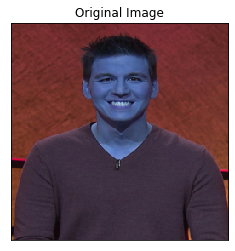

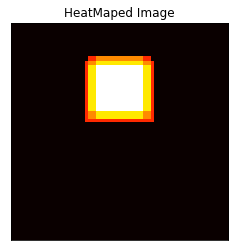

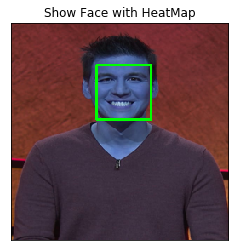

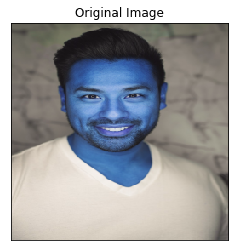

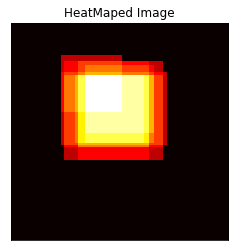

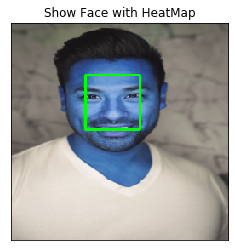

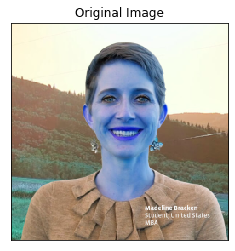

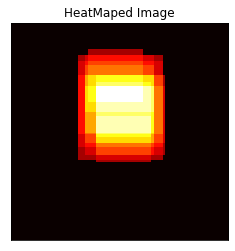

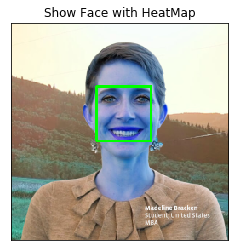

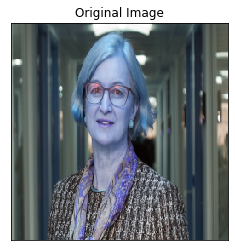

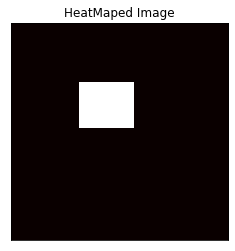

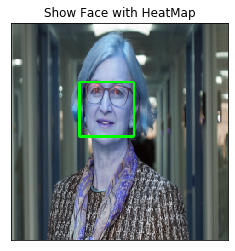

In [20]:
import matplotlib.pyplot as plt
import numpy as np
ii = np.array([0, 1, 4, 2],np.uint8())
w,h = 64,64
for i in ii:
    folderpath = 'Test_images\\test_image'+str(i+1)+'.jpg'
    O_image = cv2.imread(folderpath)
    O_image = cv2.resize(O_image,(256, 256), interpolation=cv2.INTER_AREA)
    cmap = "hot"
    image = heat_map(folderpath)
    image = image[0]
    image = image[0:255,0:255]
    pix_max = np.ndarray.max(image)
    plt.imshow(image,cmap=cmap), plt.title("HeatMaped Image")
    plt.xticks([]), plt.yticks([]), plt.show()
    image1 = np.zeros((255,255),np.float32())
    img = image.copy()
    for (x,y), pixel in np.ndenumerate(img):
        if pixel == (pix_max):
            x0 =x
            y0 =y
            break
    image2 = cv2.rectangle(O_image,(y0, x0), (y0+h, x0+w),(0, 255, 0), 2)
#     for i in range(0, 62):
#         for j in range(0,47):
#             image1[x0+i, y0+j]=255       

    plt.imshow(image2,cmap="gray", vmin = 0, vmax = 255),plt.title("Show Face with HeatMap")
    plt.xticks([]), plt.yticks([]), plt.show()